In [74]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve,auc, accuracy_score
from sklearn.feature_selection import chi2, VarianceThreshold, SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from scipy.stats import chi2_contingency

from src.data_processing import football_utils
from src.data_processing import football_repoistory
from src.data_processing import goals_preprocess_feature
from src.data_processing import lm_winner_preprocess_feature
from src.data_processing import points_preprocess_feature
from src.data_processing import possession_preprocess_feature
from src.data_processing import streaks_preprocess_feature
from src.data_processing import bets_preprocess_feature
from src.data_processing import football_preprocess_features

sns.set_context('paper')

# to reload modules
# %load_ext autoreload
# %autoreload 2

import logging

In [3]:
logger = logging.getLogger(__name__)

In [4]:
# Load data from db to file
football_repoistory.load_and_chunk_data()

In [5]:
df_detailed_matches = pd.read_csv(r'C:\Users\kamil\Documents\eu_soccer_ml\chunk_data\chunk_1.csv')

In [6]:
# profile = ProfileReport(df_detailed_matches, title='Detailed matches', minimal=True)
# profile.to_file(output_file="report/first_profile.html")

In [7]:
df_detailed_matches['date'] = pd.to_datetime(df_detailed_matches['date']).dt.date
df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']] = df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']].astype('category')

df_detailed_matches = df_detailed_matches.drop(['PSH', 'PSD', 'PSA'], axis=1)

In [8]:
# Retrieve all teams
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

In [9]:
# Count how many goals team get in last match
df_detailed_matches = goals_preprocess_feature.count_last_match_goals(df_detailed_matches, teams)
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'lm_goals_home', 'lm_goals_away')


In [10]:
# Count average goals team get in last n matches
df_detailed_matches = goals_preprocess_feature.count_average_goals_from_last_n_matches(df_detailed_matches, teams)
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'avg_l5m_h', 'avg_l5m_hh')
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'avg_l5m_a', 'avg_l5m_aa')

In [11]:
# Count streak wins or lose in last matches
df_detailed_matches = streaks_preprocess_feature.count_streak_wins(df_detailed_matches, teams)
df_detailed_matches = streaks_preprocess_feature.count_streak_lose(df_detailed_matches, teams)

In [12]:
# Process xml column, get team possession in last match
df_detailed_matches = possession_preprocess_feature.xml_to_feature_possession(df_detailed_matches)
df_detailed_matches_nan_possession = df_detailed_matches.loc[(df_detailed_matches['awaypos'].isna()) | (df_detailed_matches['homepos'].isna())]
df_detailed_matches = possession_preprocess_feature.fill_nan_possession(df_detailed_matches, df_detailed_matches_nan_possession)
df_detailed_matches = possession_preprocess_feature.get_last_match_possession(df_detailed_matches, teams)
df_detailed_matches = df_detailed_matches.drop(['homepos', 'awaypos'], axis=1)

In [13]:
# Count days since last match
df_detailed_matches = football_preprocess_features.count_days_since_last_match(df_detailed_matches, teams)

In [14]:
# Get last match winner between teams
df_detailed_matches = lm_winner_preprocess_feature.get_last_match_winner(df_detailed_matches)
df_detailed_matches = lm_winner_preprocess_feature.fill_nan_last_match_winner(df_detailed_matches)

In [15]:
# Count team points
df_detailed_matches = points_preprocess_feature.count_points(df_detailed_matches, teams)

In [16]:
# Count team average points from n last matches
df_detailed_matches = points_preprocess_feature.count_average_points_from_n_last_matches(df_detailed_matches, teams)
df_avg_goals_nan = df_detailed_matches.loc[(df_detailed_matches['avg_points_l5m_h'].isna()) | (df_detailed_matches['avg_points_l5m_a'].isna())]
df_detailed_matches = points_preprocess_feature.fill_nan_average_points(df_detailed_matches, df_avg_goals_nan)

In [17]:
df_detailed_matches = bets_preprocess_feature.fill_nan_bets(df_detailed_matches)

In [30]:
X = df_detailed_matches.drop(axis=1, columns=['home_team_goal', 'away_team_goal', 'possession', 'result_match', ])
y = df_detailed_matches['result_match']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=333)
match_api_id = X_train.pop('match_api_id')

In [31]:
# profile = ProfileReport(pd.concat([X,y], axis=1), title='Detailed matches', dark_mode=True, minimal=True)
# profile.config.interactions.targets = []
# profile.to_file(output_file="report/second_profile.html")


In [57]:
df_describe_num = X_train.select_dtypes(include='number').describe()
df_describe_num = df_describe_num.round(2)
df_describe_num

,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,streak_lh,streak_la,last_match_possession_away,last_match_possession_home,days_since_lma,days_since_lmh,points_home,points_away,avg_points_l5m_h,avg_points_l5m_a
count,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,...,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00
mean,18.30,2.54,3.71,4.66,2.47,3.65,4.35,2.42,3.58,4.30,...,1.92,1.63,49.80,48.14,9.95,9.69,22.02,22.40,1.31,1.38
std,10.89,1.61,0.93,3.51,1.47,0.90,2.92,1.43,0.82,2.93,...,2.37,2.30,7.84,7.66,22.41,15.76,15.55,15.72,0.41,0.46
min,1.00,1.04,1.53,1.10,1.03,1.65,1.10,1.04,1.44,1.10,...,0.00,0.00,21.00,4.00,2.00,2.00,0.00,0.00,0.40,0.40
25%,9.00,1.67,3.25,2.63,1.65,3.20,2.55,1.67,3.20,2.50,...,0.00,0.00,45.00,44.00,6.00,6.00,9.00,9.00,1.00,1.00
50%,18.00,2.10,3.40,3.60,2.10,3.35,3.45,2.10,3.30,3.40,...,1.00,1.00,49.00,48.00,7.00,7.00,20.00,20.00,1.29,1.40
75%,28.00,2.70,3.75,5.50,2.65,3.70,5.05,2.60,3.60,5.00,...,3.00,2.00,55.00,53.00,8.00,8.00,34.00,34.00,1.71,1.80
max,38.00,23.00,13.00,34.00,21.00,15.00,31.00,17.00,12.00,26.00,...,20.00,18.00,80.00,78.00,818.00,455.00,71.00,72.00,2.60,2.60


In [58]:
# Remove outliers
def remove_outliers(df,columns,n_std):
    for col in columns:
        # print('Working on column: {}'.format(col))
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
    return df

X_train_out = remove_outliers(X_train, X_train.select_dtypes(include='number').columns, 3)

>Threshold=0.00, Features=31
>Threshold=0.05, Features=31
>Threshold=0.10, Features=31
>Threshold=0.15, Features=31
>Threshold=0.20, Features=30
>Threshold=0.25, Features=29
>Threshold=0.30, Features=29
>Threshold=0.35, Features=29
>Threshold=0.40, Features=28
>Threshold=0.45, Features=26
>Threshold=0.50, Features=26


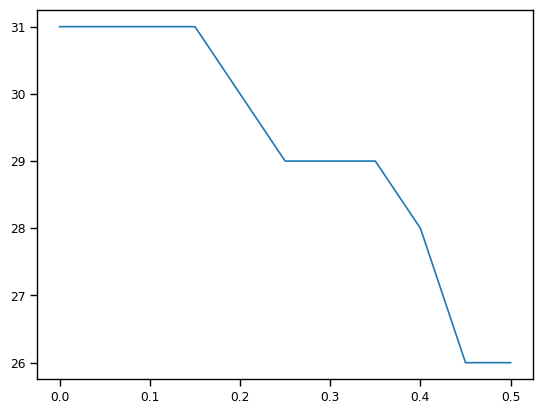

In [59]:
# Remove low variance features

thresholds = np.arange(0.0, 0.55, 0.05)
results = list()

for t in thresholds:
    v_threshold = VarianceThreshold(threshold=t)
    X_sel = v_threshold.fit_transform(X_train.select_dtypes(include='number'))
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    results.append(n_features)

plt.plot(thresholds, results)
plt.show()

In [61]:
v_threshold = VarianceThreshold(threshold=0.21)
X_sel = v_threshold.fit_transform(X_train.select_dtypes(include='number'))
X_sel = pd.DataFrame(data=X_sel, columns=v_threshold.get_feature_names_out())
print(X_sel.shape)

(3995, 29)


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_describe_num = pd.DataFrame(data=StandardScaler().fit_transform(X_train.select_dtypes(include='number')), columns=X_train.select_dtypes(include='number').columns)

pca = PCA(0.95)

principalComponents = pca.fit_transform(df_describe_num)

principalDf = pd.DataFrame(data=principalComponents, columns=['principal_component_1', 'principal_component_2', 'principal_component_3', 'principal_component_4',
                                                'principal_component_5', 'principal_component_6', 'principal_component_7', 'principal_component_8',
                                                'principal_component_9', 'principal_component_10', 'principal_component_11', 'principal_component_12',
                                                # 'principal_component_13', 'principal_component_14', 'principal_component_15', 'principal_component_`16'
                                                              ])

In [65]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf = finalDf.loc[:1000]

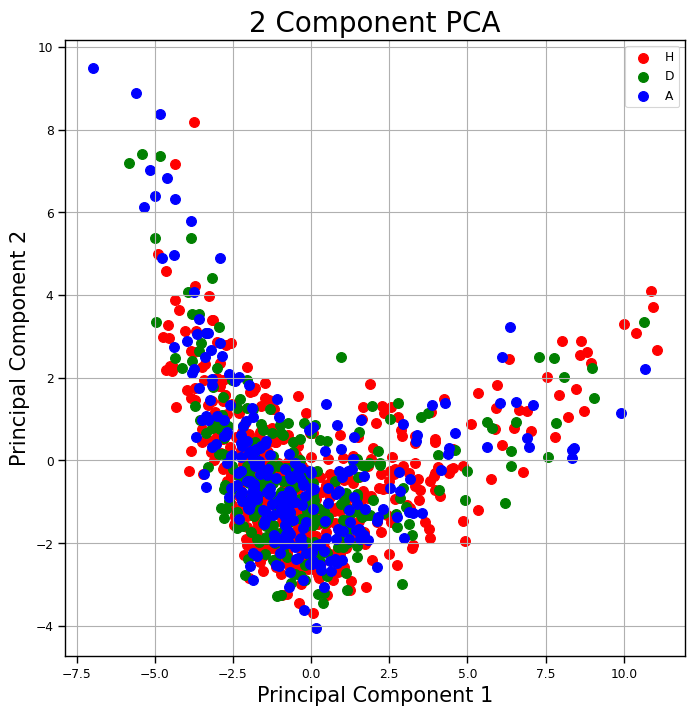

In [66]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['H', 'D', 'A']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[ 'result_match'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal_component_1']
               ,finalDf.loc[indicesToKeep, 'principal_component_2']
               ,c = color
               ,s = 50)
ax.legend(targets)
ax.grid()

Text(0, 0.5, 'Proportion of Variance Explained')

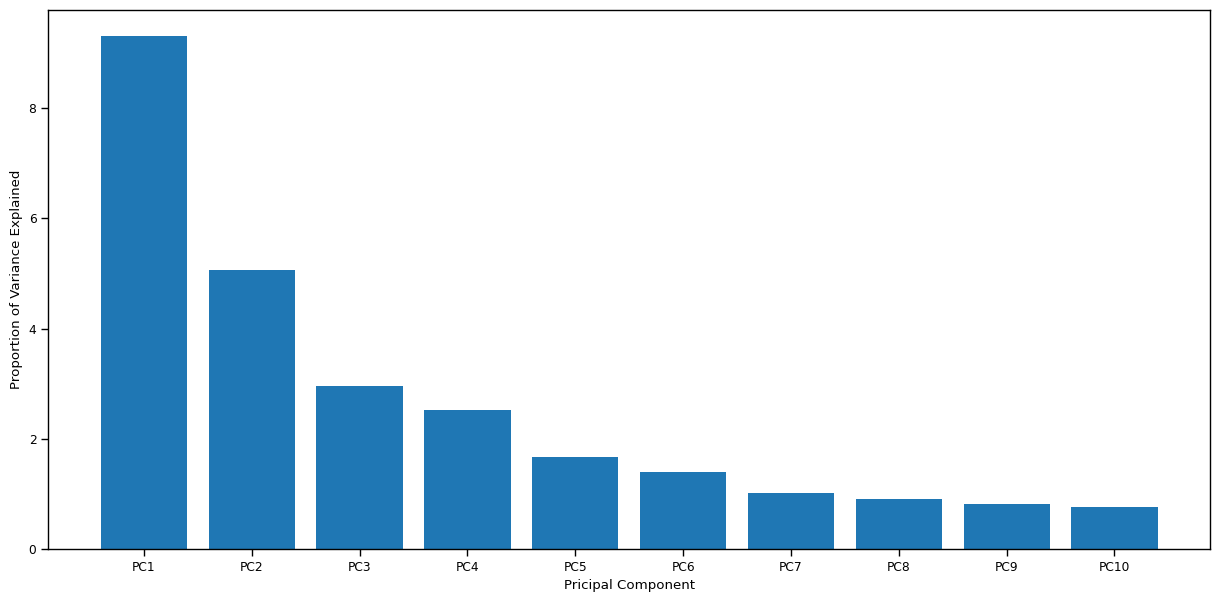

In [67]:
var = pca.explained_variance_[0:10] #percentage of variance explained
labels = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']

plt.figure(figsize=(15,7))
plt.bar(labels,var,)
plt.xlabel('Pricipal Component')
plt.ylabel('Proportion of Variance Explained')

In [21]:
df_describe_cat = X_train.select_dtypes(exclude='number').describe()
df_describe_cat = df_describe_cat.round(2)
df_describe_cat

,country_name,league_name,season,date,home_team,away_team,lm_winner
count,4994,4994,4994,4994,4994,4994,4994
unique,5,5,4,526,128,128,127
top,England,England Premier League,2010/2011,2011-05-07,Liverpool,RCD Espanyol,Draw
freq,1249,1249,1674,32,63,63,1242


In [85]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(data=oe.transform(X_train), columns=X_train.columns)
    X_test_enc = pd.DataFrame(data=oe.transform(X_test), columns=X_test.columns)
    return X_train_enc, X_test_enc

def prepare_target(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

def select_categorical_feature(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = pd.DataFrame(fs.transform(X_train), columns=fs.get_feature_names_out())
    X_test_fs = pd.DataFrame(fs.transform(X_test), columns=fs.get_feature_names_out())
    return X_train_fs, X_test_fs, fs

In [86]:
X_cat_train_enc, X_cat_test_enc = prepare_inputs(X_train.select_dtypes(exclude=['number']), X_test.select_dtypes(exclude=['number']))
y_train_enc, y_test_enc = prepare_target(y_train, y_test)

print(f'X_train, inputs: {X_cat_train_enc.shape}, target: {y_train_enc.shape}')
print(f'X_train, inputs: {X_cat_test_enc.shape}, target: {y_test_enc.shape}')

X_train, inputs: (3995, 7), target: (3995,)
X_train, inputs: (999, 7), target: (999,)


In [95]:
X_cat_train_enc_fs, X_cat_test_enc_fs, fs = select_categorical_feature(X_cat_train_enc, y_train_enc, X_cat_test_enc)

for i in range(len(fs.scores_)):
    print(f'Feature %d: %s, %f' % (i, fs.get_feature_names_out()[i], fs.scores_[i]))

Feature 0: country_name, 7.239183
Feature 1: league_name, 7.239183
Feature 2: season, 0.497430
Feature 3: date, 81.002884
Feature 4: home_team, 2.665099
Feature 5: away_team, 75.739217
Feature 6: lm_winner, 301.950590


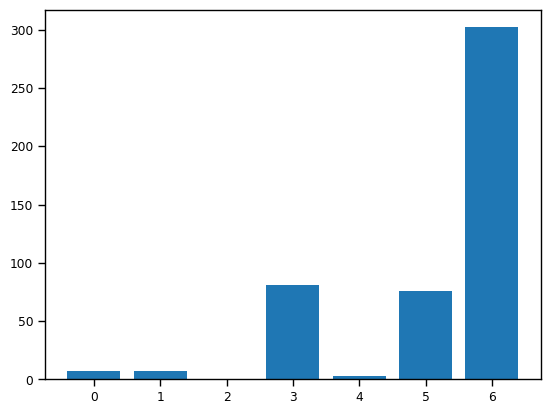

In [94]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [22]:
# change target to binary
# X_drop['home_winner'] = df_detailed_matches.result_match.apply(lambda x: football_utils.preprocess_category_string(x))
# X_drop['home_winner'].value_counts()

no     2604
yes    2390
Name: home_winner, dtype: int64

In [23]:
sns.set_style('darkgrid')

In [ ]:
points_bookmark_sum = points_preprocess_feature.aggregate_result_match_points(df_detailed_matches, 'points_home', 'points_away')

points_bookmark_sum = points_bookmark_sum.groupby(['type']).sum().loc[:, ['good_points', 'wrong_points']]
points_bookmark_sum.plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets by team with higher points.')
plt.show()


In [24]:
from sklearn import preprocessing

df_temp = df_detailed_matches.drop(axis=1, columns=['home_team_goal', 'away_team_goal', 'possession'])
encoder = preprocessing.LabelEncoder()
encoder.fit(df_temp['result_match'])
df_temp['result_match'] = encoder.transform(df_temp['result_match'])

In [25]:
# all_data_plot = sns.pairplot(df_temp)
# all_data_plot.savefig('plot/all_data_plot.png')

In [26]:
bet_cols_to_plot = ['result_match', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD', 'WHA']
goals_cols_to_plot = ['result_match', 'avg_l5m_a', 'avg_l5m_h', 'avg_l5m_aa', 'avg_l5m_hh', 'lm_goals_away', 'lm_goals_home', 'streak_la', 'streak_lh', 'streak_wa', 'streak_wh', 'WHA']


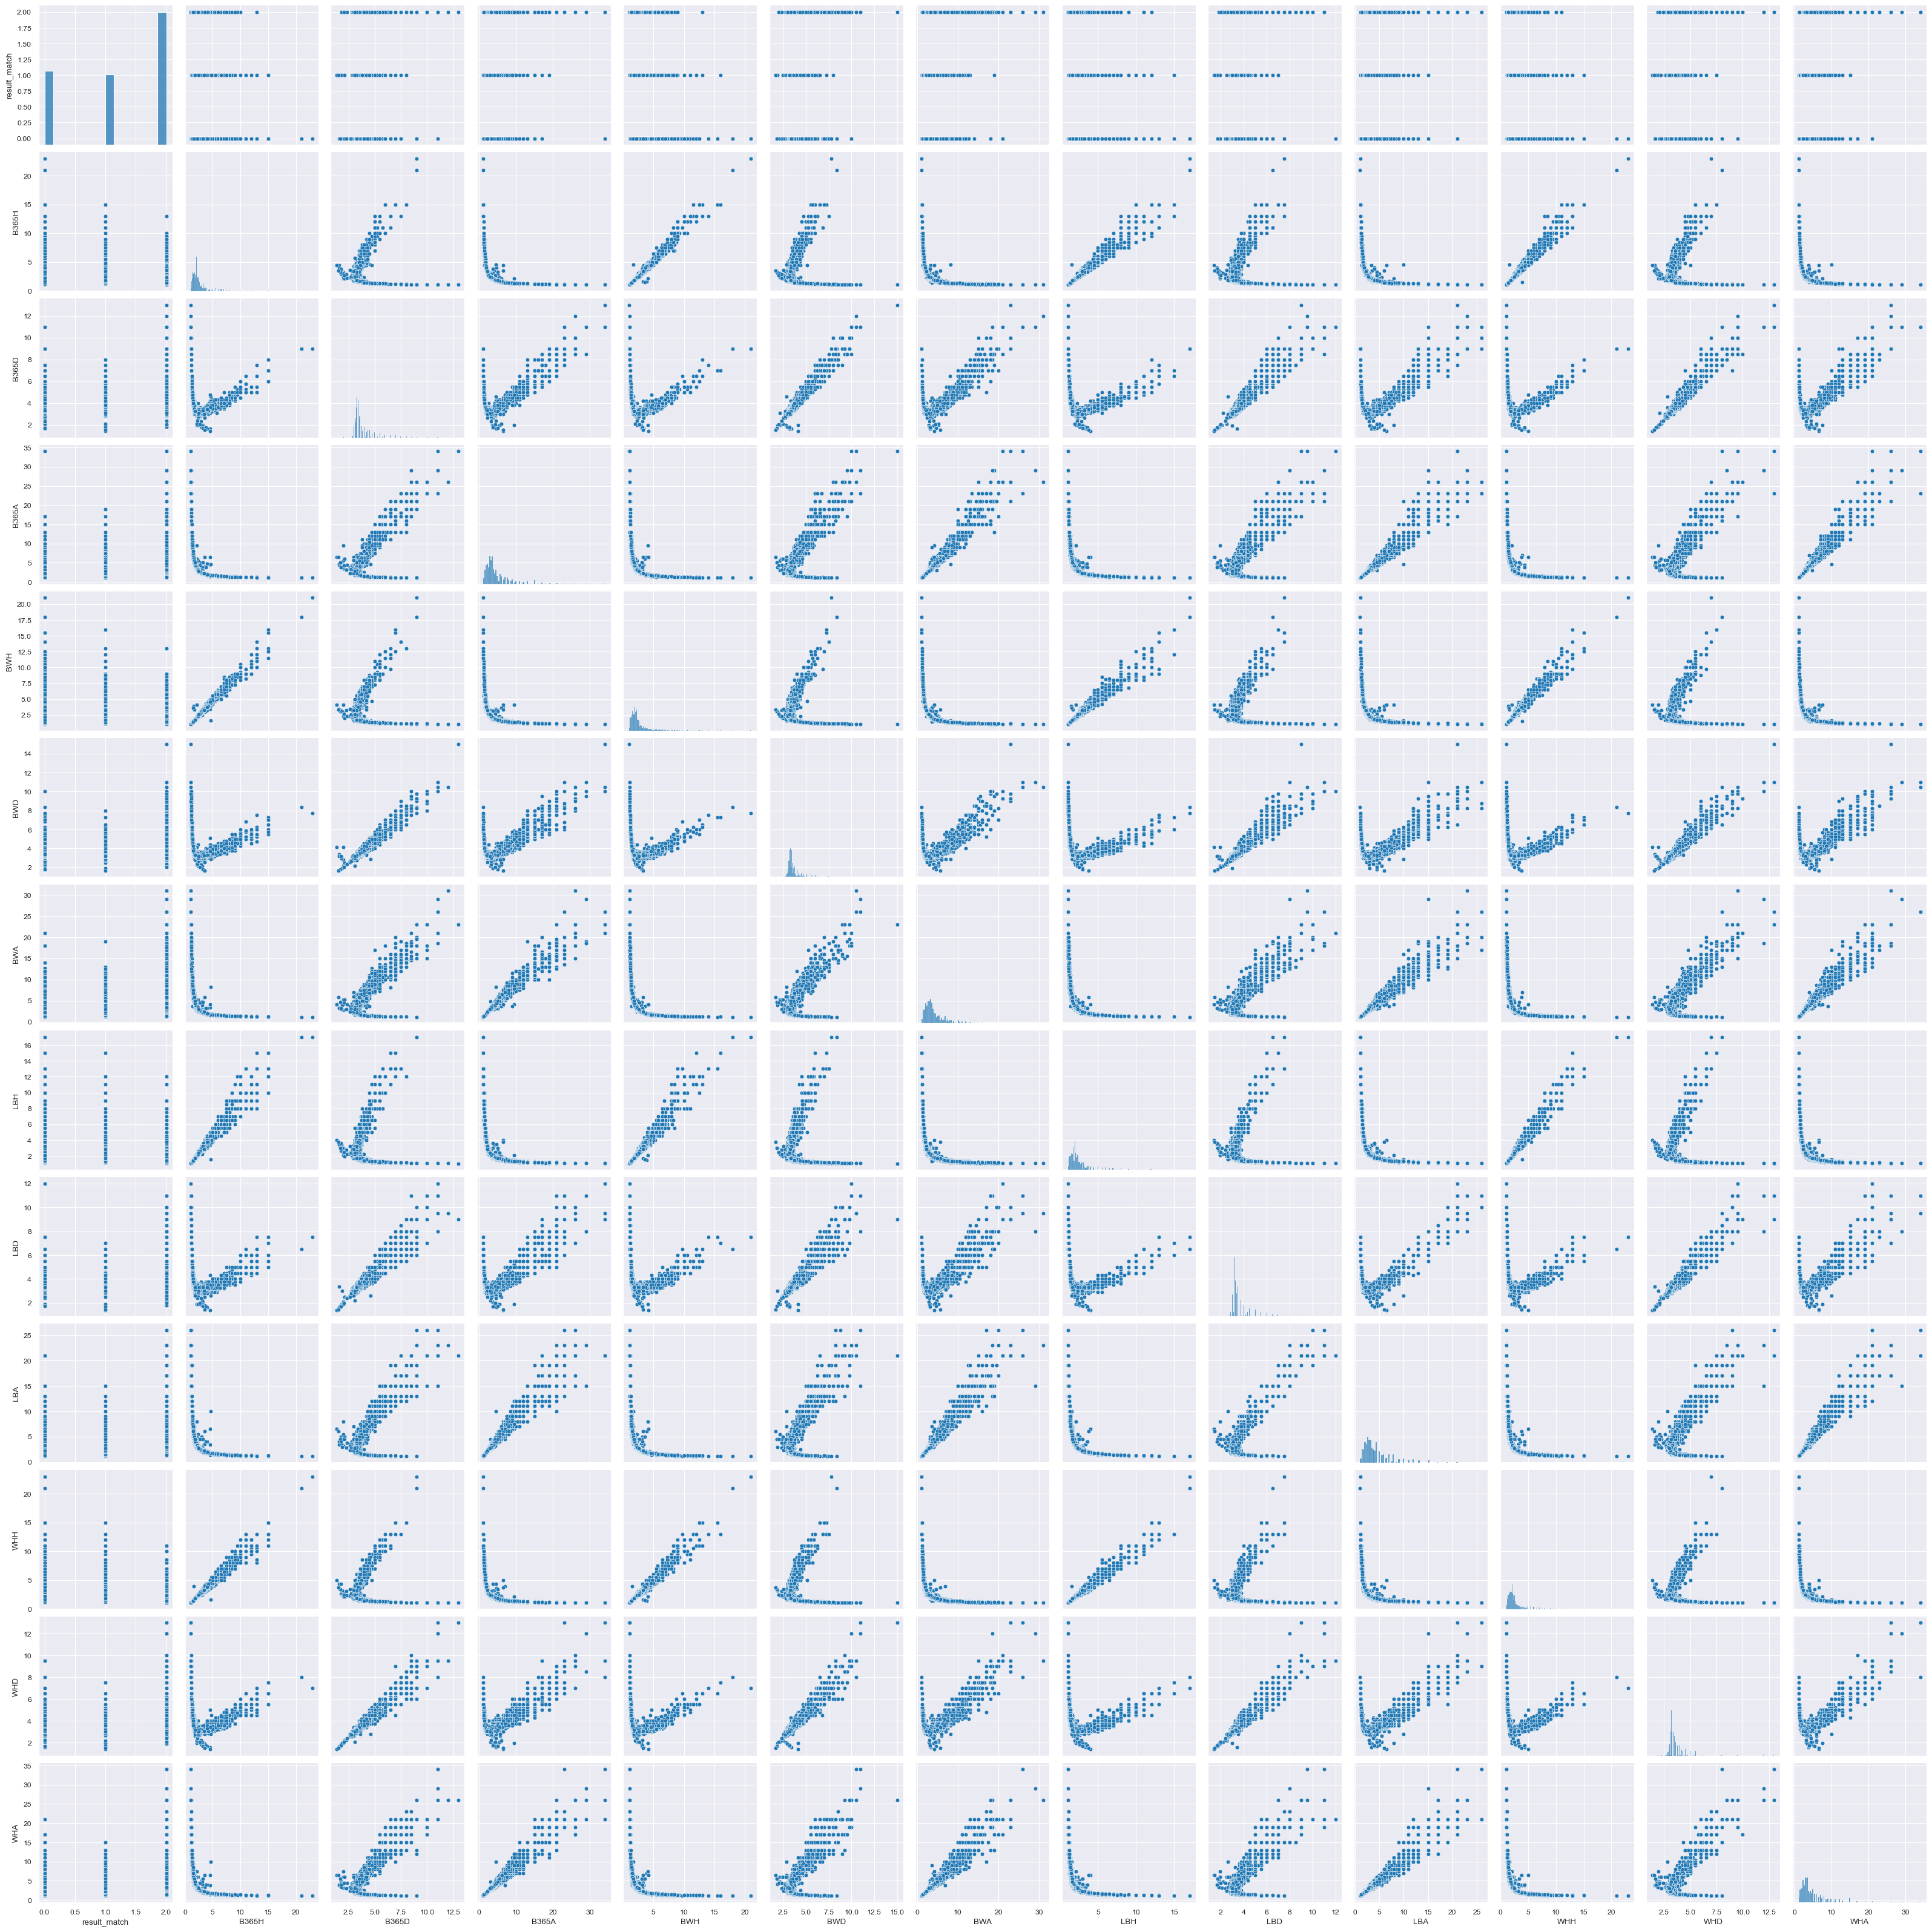

In [27]:
sns.pairplot(df_temp[bet_cols_to_plot])

In [28]:

# df_drop[['result_match', 'B365H', 'B365A']].groupby('result_match')
# .aggregate({'B365H': ['mean'], 'B365A': ['mean']})
# .reset_index()
# .sort_values(('loss', 'mean'), ascending=False)

value counts: 
H    2390
A    1338
D    1266
Name: result_match, dtype: int64


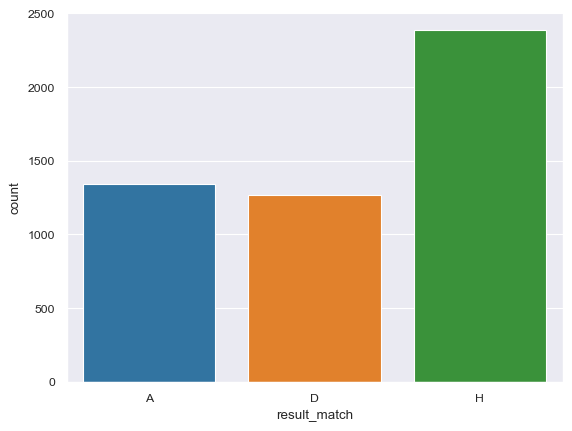

In [29]:
print(f'value counts: \n{df_detailed_matches.result_match.value_counts()}')
sns.countplot(x='result_match',data=df_detailed_matches)
plt.show()


In [30]:
df_scoring_bet = pd.DataFrame(columns=['bookmaker', 'type', 'good_bet', 'wrong_bet'])

In [31]:
b365_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'B365H', 'B365D', 'B365A')
bw_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'BWH', 'BWD', 'BWA')
lb_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'LBH', 'LBD', 'LBA')
wh_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'WHH', 'WHD', 'WHA')

In [32]:
bets_bookmark_res = pd.concat([bw_df, lb_df, b365_df, wh_df])
bets_bookmark_res = bets_bookmark_res.set_index(['bookmaker', 'type'])

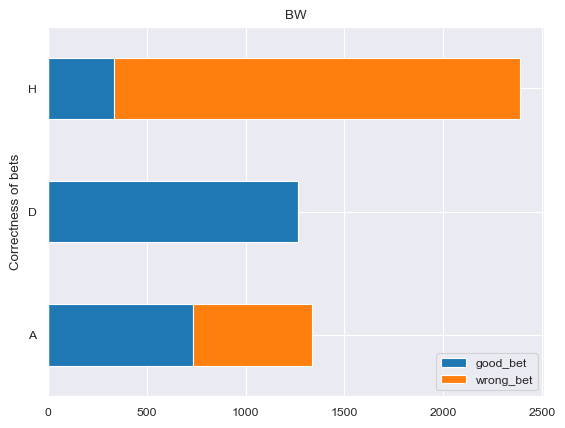

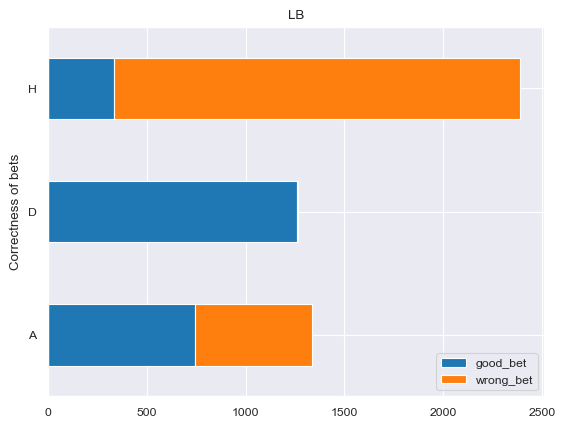

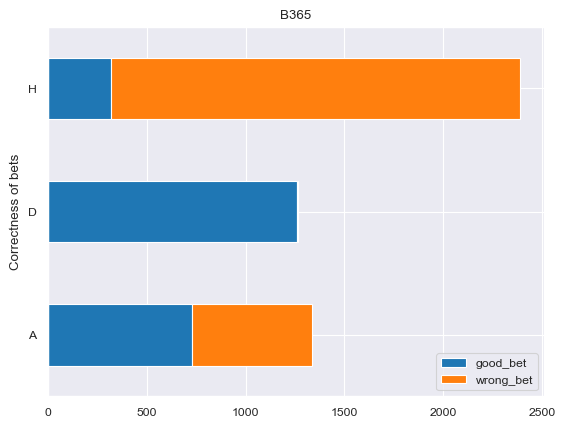

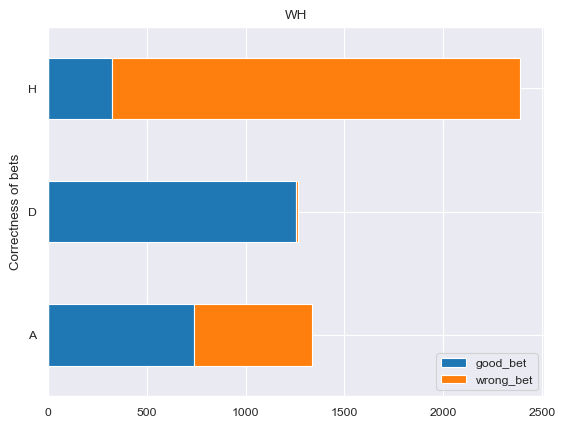

In [33]:
uniques = bets_bookmark_res.index.get_level_values(0).unique()
for i in list(uniques):
    df_single = bets_bookmark_res.loc[i]
    df_single.plot(kind='barh',stacked=True, title=i, xlabel='Correctness of bets')
    plt.show()

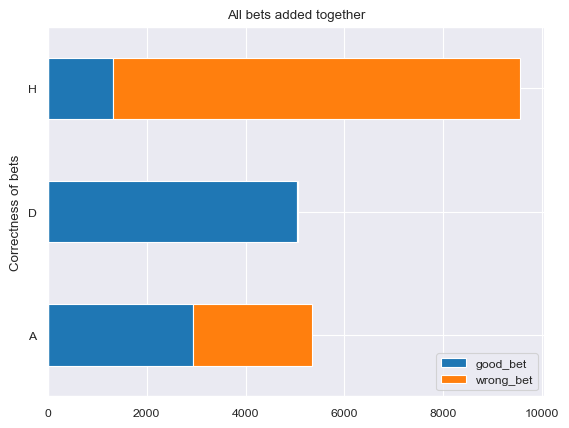

In [34]:
bets_bookmark_sum = bets_bookmark_res.droplevel(0).groupby(['type']).sum().loc[:, ['good_bet', 'wrong_bet']]
bets_bookmark_sum.plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')
plt.show()

In [35]:
streak_df = df_detailed_matches[['streak_wh', 'streak_wa', 'streak_lh', 'streak_la', 'result_match']]

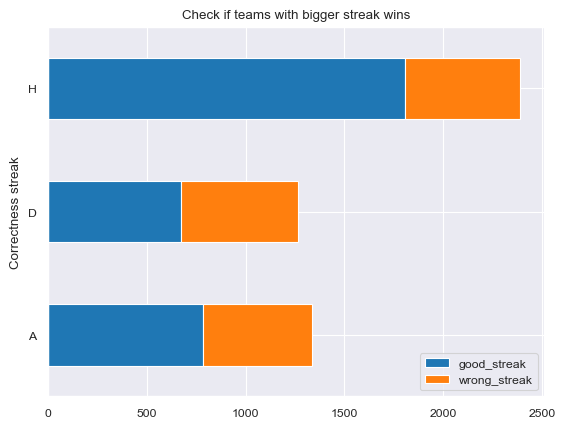

In [36]:
streak_df_agg = football_utils.aggregate_streaks(df_detailed_matches, 'streak_wh', 'streak_wa')
streak_df_agg.set_index(keys='type', inplace=True)
streak_df_agg.plot(kind='barh',stacked=True, title='Check if teams with bigger streak wins', xlabel='Correctness streak')
plt.show()

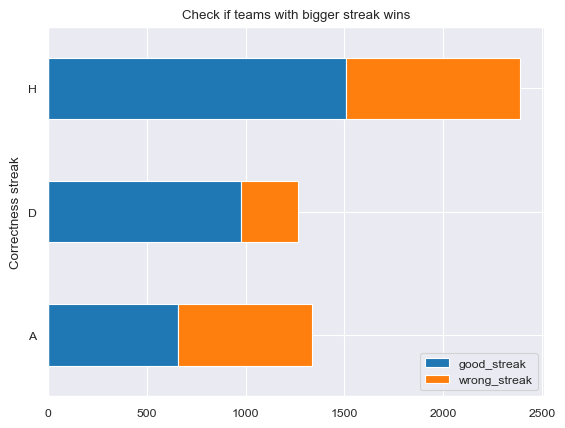

In [37]:
streak_df_agg_a = football_utils.aggregate_streaks(df_detailed_matches, 'streak_la', 'streak_lh')#%%
streak_df_agg_a.set_index(keys='type', inplace=True)
streak_df_agg_a.plot(kind='barh',stacked=True, title='Check if teams with bigger streak wins', xlabel='Correctness streak')
plt.show()

In [38]:
df_detailed_matches['streak_vs_win'] = streak_df[['streak_wh', 'streak_wa']].apply(lambda x: football_utils.check_streak_with_win_probability(x, 'streak_wh', 'streak_wa'), axis=1)
# df_drop['streak_vs_win'].plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')

df_detailed_matches['streak_vs_win'].value_counts()

False    4994
Name: streak_vs_win, dtype: int64

In [39]:
df_detailed_matches.drop(['streak_vs_win'], axis=1, inplace=True)

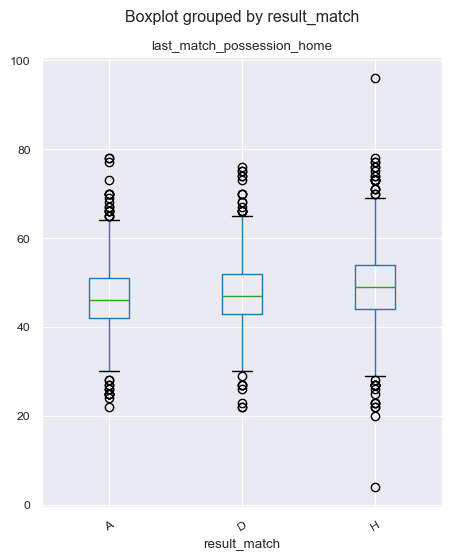

count    4991.000000
mean       48.156482
std         7.645985
min        22.000000
25%        44.000000
50%        48.000000
75%        53.000000
max        78.000000
Name: last_match_possession_home, dtype: float64

In [40]:
df_detailed_matches.boxplot('last_match_possession_home', 'result_match', rot=30, figsize=(5, 6))
plt.show()
# probably cols to remove, check feature importance
df_detailed_matches['last_match_possession_home'].loc[(df_detailed_matches['last_match_possession_home'] < 80) & (df_detailed_matches['last_match_possession_home'] > 20)].describe()

In [41]:
df_detailed_matches.select_dtypes(exclude=['number']).nunique()

country_name       5
league_name        5
season             4
date             526
home_team        128
away_team        128
possession      2971
result_match       3
lm_winner        127
dtype: int64

In [ ]:
df_ = X_drop.drop(['home_winner'], axis=1)
y_ = X_drop['home_winner']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_.drop('result_match', axis =1), df_.result_match, test_size = 0.2, random_state=333)

In [83]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)

In [77]:
# Work with both cat and num features, use before encoding on all dataset
from feature_engine.selection import DropConstantFeatures
drop_constant_features = DropConstantFeatures(tol=0.95)
drop_constant_features.fit(X_train)
drop_constant_features.features_to_drop_

[]

In [86]:
numerical_columns = X_train.select_dtypes(include=['number']).columns

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train[numerical_columns], y_train)
X_test_t = scaler.transform(X_test[numerical_columns])

In [125]:
from feature_engine.selection import DropCorrelatedFeatures

tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
Xt = tr.fit_transform(X_train[numerical_columns])

print(tr.correlated_feature_sets_)

[{'points_home', 'points_away', 'stage'}, {'WHH', 'LBH', 'BWH', 'B365H'}, {'WHD', 'WHA', 'LBD', 'BWA', 'BWD', 'B365D', 'B365A', 'LBA'}]


In [126]:
tr.correlated_feature_sets_

[{'points_away', 'points_home', 'stage'},
 {'B365H', 'BWH', 'LBH', 'WHH'},
 {'B365A', 'B365D', 'BWA', 'BWD', 'LBA', 'LBD', 'WHA', 'WHD'}]

In [127]:
print(print(Xt.columns))

Index(['stage', 'B365H', 'B365D', 'lm_goals_away', 'lm_goals_home',
       'avg_l5m_hh', 'avg_l5m_h', 'avg_l5m_aa', 'avg_l5m_a', 'streak_last_wh',
       'streak_last_wa', 'streak_last_lh', 'streak_last_la',
       'last_match_possession_away', 'last_match_possession_home',
       'days_since_lma', 'days_since_lmh', 'avg_points_l5m_h',
       'avg_points_l5m_a', 'date_year', 'date_month', 'date_day'],
      dtype='object')
None


In [137]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(Xt, y_train)

# All features
predictions = classifier.predict(X_test[Xt.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.44789579158316634
              precision    recall  f1-score   support

           A       0.37      0.29      0.32       271
           D       0.26      0.21      0.23       243
           H       0.54      0.66      0.59       484

    accuracy                           0.45       998
   macro avg       0.39      0.38      0.38       998
weighted avg       0.42      0.45      0.43       998



In [138]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train[numerical_columns], y_train)

# All features
predictions = classifier.predict(X_test[numerical_columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.4498997995991984
              precision    recall  f1-score   support

           A       0.41      0.35      0.38       271
           D       0.23      0.18      0.20       243
           H       0.54      0.64      0.58       484

    accuracy                           0.45       998
   macro avg       0.39      0.39      0.39       998
weighted avg       0.43      0.45      0.43       998



In [63]:
categorical_columns = df_.drop('result_match', axis=1).select_dtypes(exclude=['number']).columns

In [64]:
# Test chi2
#Testing the relationship
chi_res = chi2_contingency(pd.crosstab(df_drop['result_match'], df_drop['lm_winner']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

property_dummies = pd.get_dummies(data = df_drop[['lm_winner', 'result_match']], columns = ['lm_winner'])

chi_res = chi2_contingency(pd.crosstab(property_dummies['result_match'], property_dummies['lm_winner_Manchester United']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 257.6162202703757, p-value: 0.35682662614984645
Chi2 Statistic: 3.4735710841091434, p-value: 0.17608551133907518


In [65]:
# OHE encoding
data_log = pd.get_dummies(data=df_, columns = df_.select_dtypes(exclude = 'number').drop('result_match', axis =1).columns, drop_first=True)
data_log['result_match'] = data_log['result_match'].apply(lambda x: 0 if x == 'H' else (1 if x == 'D' else 2))

X_train, X_test, y_train, y_test = train_test_split(data_log.drop('result_match', axis =1), data_log['result_match'], test_size = 0.2, random_state=333)

N_NEIGHBORS = 8

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [66]:
# All features
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.48296593186372744
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       484
           1       0.27      0.18      0.22       243
           2       0.47      0.25      0.33       271

    accuracy                           0.48       998
   macro avg       0.42      0.40      0.39       998
weighted avg       0.45      0.48      0.45       998



In [67]:
OHE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)
OHE_X.shape

(3989, 20)

In [68]:
# SelectKBest chi-square, One hot encoding

#Training the model only with the significant features and the numerical features
classifier1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier1.fit(OHE_X, y_train)
#Metrics check
predictions = classifier1.predict(X_test[OHE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.5130260521042084
              precision    recall  f1-score   support

           0       0.56      0.76      0.65       484
           1       0.36      0.25      0.29       243
           2       0.47      0.30      0.37       271

    accuracy                           0.51       998
   macro avg       0.46      0.44      0.44       998
weighted avg       0.49      0.51      0.49       998



In [69]:
X_enc = df_.copy()

# prepare input features
oe = OrdinalEncoder()
X_enc[df_.columns] = oe.fit_transform(df_)

# prepare target variable
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = 0.2, random_state=333)
OE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)

In [71]:
# SelectKBest chi-square, Ordinal encoding

#Training the model only with the significant features and the numerical features
classifier2 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier2.fit(OE_X, y_train)
#Metrics check
predictions = classifier2.predict(X_test[OE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.467935871743487
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       271
           1       0.23      0.16      0.19       243
           2       0.58      0.63      0.60       484

    accuracy                           0.47       998
   macro avg       0.41      0.42      0.41       998
weighted avg       0.45      0.47      0.46       998



In [68]:
# number of categorical features
print("Number of categorical features : {}".format(len(df_.select_dtypes(include=['object', 'category']).columns)))
print("Number of continuous features : {}".format(len(df_.select_dtypes(include=['number']).columns)))


Number of categorical features : 7
Number of continuous features : 34


c:\users\kamil\documents\eu_soccer_ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


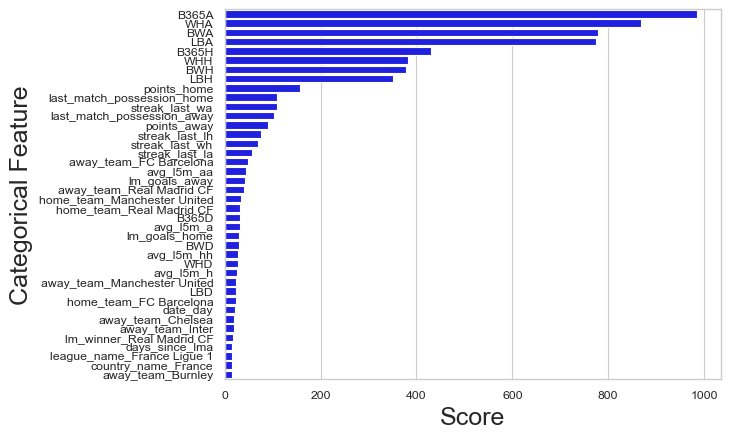

In [104]:
# categorical feature selection
sf = football_utils.SelectKBest(chi2, k=30)
sf_fit = sf.fit(X_train, y_train)

# plot the scores
datset = pd.DataFrame()
datset['feature'] = X_train.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset.iloc[:40]['scores'], datset.iloc[:40]['feature'], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [ ]:
# Decision boundary graph
data = X_train.select_dtypes(include=['number']).loc[:100, ['avg_l5m_h', 'B365H']]
def plot_decision_boundries(X, y, n_neighbors=1):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)

    x_min, x_max = X.iloc[:, 0].min() - 3, X.iloc[:, 0].max() + 3
    y_min, y_max = X.iloc[:, 1].min() - 3, X.iloc[:, 1].max() + 3

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    z = clf.predict(mesh)
    z = z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, z, cmap='gnuplot', alpha=0.1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='gnuplot', edgecolors='r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'3-class classification k={n_neighbors}')
    plt.show()


plot_decision_boundries(data, y_train.loc[:100], n_neighbors=N_NEIGHBORS)

In [ ]:
#Creating the ROC-AUC plot, * multiclass format is not supported
preds = classifier.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 4))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=["class_H", "class_D", "class_A"],
)

cmp.plot(ax=ax)
plt.show();

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = 0.2, random_state=333)

model_dataset = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred_dataset = model_dataset.predict(X_test)

print(accuracy_score(y_test, pred_dataset))
print(classification_report(y_test,predictions))

0.46993987975951906
              precision    recall  f1-score   support

           0       0.23      0.59      0.34       271
           1       0.27      0.18      0.22       243
           2       0.26      0.08      0.12       484

    accuracy                           0.24       998
   macro avg       0.25      0.28      0.22       998
weighted avg       0.25      0.24      0.20       998



In [147]:
np.unique(y_train)

array([0, 1, 2])

In [148]:
np.unique(y_test)

array([0, 1, 2])

In [149]:
X_train_enc_ = sf_fit1.X_train_t(X_enc)

X_train_enc_new, X_test_enc_new, y_train_enc_new, y_test_enc_new = train_test_split(X_train_enc_, y_enc, test_size = 0.2, random_state=333)

model_dataset_1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train_enc_new, y_train_enc_new)
pred_dataset_1 = model_dataset_1.predict(X_test_enc_new)

print(accuracy_score(y_test_enc_new, pred_dataset_1))
print(classification_report(y_test_enc_new,pred_dataset_1))

0.4909819639278557
              precision    recall  f1-score   support

           0       0.44      0.49      0.46       271
           1       0.29      0.19      0.23       243
           2       0.58      0.64      0.61       484

    accuracy                           0.49       998
   macro avg       0.44      0.44      0.44       998
weighted avg       0.47      0.49      0.48       998



In [ ]:
# _ = sns.pairplot(df_drop, vars=df_drop.select_dtypes(include=['number']), hue='result_match')
# plt.savefig('plot/pair_plot.png')

In [122]:
len(datset.iloc[:5]['scores'])

5

In [ ]:
df_num = df_drop.select_dtypes(include='number')
df_cat = df_drop.select_dtypes(exclude='number')

In [ ]:
le = preprocessing.LabelEncoder()
X = df_drop
y = le.fit_transform(X.home_winner)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

In [ ]:
X = X.drop(['result_match', 'homer_winner'])

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
